### Developing a real stratergy to invest in the stock market

When developing our stratergy, the goal will be to acquire good and useful information about each stock. We then need to check which parameters play a role in explaining variation in the data and which simply contribute noise to the system. Once we have generated and calculated the financial indicators and then optimised the tuning of these params using something like simulated annealing to search the complex solution space we can test and compare our stratergy against the S&P500 real life data. 

Sentiment data could be useful, financial statements even better, unsure how to extract, useful information from these datasets.

Looking for monthly readjustments for our stock portfolio. Further investigation should be carried 
on arbitrage. 

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import os

In [24]:
tickers = ["AAPL", "MSFT", "GOOGL"]

# URL for S&P 500 companies on Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Read the first table from the Wikipedia page
# sp500_table = pd.read_html(url)[0]

# Extract the ticker symbols
# tickers = sp500_table['Symbol'].tolist()
# print(tickers)


start_date = "2018-01-01"
end_date = "2024-12-31"

In [25]:
def download_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
    return stock_data

data = download_stock_data(tickers, start_date, end_date)

# data_folder = "C:/Users/codyr/Desktop/Coding_/Quant_Trading_Basics"

# data = pd.read_csv("C:/Users/codyr/Desktop/Coding_/Quant_Trading_Basics/AAPL_stock_data.csv")

data.head()

# data.to_csv('AAPL_stock_data.csv', index=True)

[*********************100%***********************]  3 of 3 completed


Ticker          GOOGL                                                        \
Price            Open       High        Low      Close  Adj Close    Volume   
Date                                                                          
2015-01-02  26.629999  26.790001  26.393999  26.477501  26.381865  26480000   
2015-01-05  26.357500  26.399500  25.887501  25.973000  25.879185  41182000   
2015-01-06  26.025000  26.060499  25.277500  25.332001  25.240501  54456000   
2015-01-07  25.547501  25.574499  25.182501  25.257500  25.166271  46918000   
2015-01-08  25.075500  25.375000  24.750999  25.345501  25.253954  73054000   

Ticker           MSFT                                                        \
Price            Open       High        Low      Close  Adj Close    Volume   
Date                                                                          
2015-01-02  46.660000  47.419998  46.540001  46.759998  40.152466  27913900   
2015-01-05  46.369999  46.730000  46.250000  46.330002  39.783230  39673900   
2015-01-06  46.380001  46.750000  45.540001  45.650002  39.199333  36447900   
2015-01-07  45.980000  46.459999  45.490002  46.230000  39.697376  29114100   
2015-01-08  46.750000  47.750000  46.720001  47.590000  40.865208  29645200   

Ticker           AAPL                                                         
Price            Open       High        Low      Close  Adj Close     Volume  
Date                                                                          
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.347170  212818400  
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.661280  257142000  
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.663498  263188400  
2015-01-07  26.799999  27.049999  26.674999  26.937500  23.995314  160423600  
2015-01-08  27.307501  28.037500  27.174999  27.972500  24.917269  237458000

In [26]:
multi_index_data = (
    data.stack(level=0, future_stack=True) # Pivot longer -> Takes ticker and makes it into a part of the index
    .swaplevel() # Swaps the order of the two index columns
    .sort_index() # Sorts the index
)

multi_index_data

Price                    Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
AAPL   2015-01-02   27.847500   27.860001   26.837500   27.332500   24.347170   
       2015-01-05   27.072500   27.162500   26.352501   26.562500   23.661280   
       2015-01-06   26.635000   26.857500   26.157499   26.565001   23.663498   
       2015-01-07   26.799999   27.049999   26.674999   26.937500   23.995314   
       2015-01-08   27.307501   28.037500   27.174999   27.972500   24.917269   
...                       ...         ...         ...         ...         ...   
MSFT   2023-12-22  373.679993  375.179993  372.709991  374.579987  371.799744   
       2023-12-26  375.000000  376.940002  373.500000  374.660004  371.879120   
       2023-12-27  373.690002  375.059998  372.809998  374.070007  371.293518   
       2023-12-28  375.369995  376.459991  374.160004  375.279999  372.494507   
       2023-12-29  376.000000  377.160004  373.480011  376.040009  373.248901   

Price                 Volume  
Ticker Date                   
AAPL   2015-01-02  212818400  
       2015-01-05  257142000  
       2015-01-06  263188400  
       2015-01-07  160423600  
       2015-01-08  237458000  
...                      ...  
MSFT   2023-12-22   17091100  
       2023-12-26   12673100  
       2023-12-27   14905400  
       2023-12-28   14327000  
       2023-12-29   18723000  

[6792 rows x 6 columns]

In [27]:
### Define and calcuate RSI 
def calculate_rsi(data, column='Adj Close', window=14):
    """
    Calculate the RSI for each stock in a multi-index df
    """
    def rsi_per_stock(data):
    
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Input data must be a pandas DataFrame")
    
        if column not in data.columns:
            raise ValueError(f"Column '{column}' not found in the DataFrame")
    
        # Calculate daily price changes (delta)
        delta = data['Adj Close'].diff()
    
        # Separate gains and losses
        gains = delta.clip(lower=0)
        losses = -delta.clip(upper=0)
        
        avg_gain = gains.rolling(window=window, min_periods=window).mean()
        avg_loss = losses.rolling(window=window, min_periods=window).mean()
    
        rs = avg_gain/avg_loss
        data['RSI'] = 100 - (100/ (1+rs)) # Ratio of avg gains/ avg losses during the window -> normalised to be 0 < rsi < 1
        
        return data
        
    return data.groupby(level='Ticker', group_keys=False).apply(rsi_per_stock)

def calculate_rsi_ewma(data, column="Adj Close", window=14):

    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    if column not in data.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame")

    def rsi_ewma_per_stock(data):
        # Calculate daily price changes (delta)
        delta = data[column].diff()
    
        # Separate gains and losses
        gains = delta.clip(lower=0)
        losses = -delta.clip(upper=0)
        
        avg_gain = gains.ewm(span=window, adjust=False).mean()
        avg_loss = losses.ewm(span=window, adjust=False).mean()
    
        rs = avg_gain/avg_loss
        rsi = 100 - (100/ (1+rs))

        data['RSI_EWMA'] = 100 - (100/ (1+rs)) # Ratio of exponentially smoothed gains/ losses during the window -> normalised to be 0 < rsi < 1
        return data
        
    return data.groupby(level='Ticker', group_keys=False).apply(rsi_ewma_per_stock)


def calculate_bollinger_bands(data, window=20):
    """
    Calculates Bollinger bands for multi-index df
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")
    
    def calculate_bb_per_stock(data):
        bb_data = data['Adj Close']

        rolling_mean = bb_data.rolling(window=window).mean()
        rolling_std = bb_data.rolling(window=window).std()

        data[('Bollinger', 'Middle Band')] = rolling_mean
        data[('Bollinger', 'Upper Band')] = rolling_mean + (2 * rolling_std)
        data[('Bollinger', 'Lower Band')] = rolling_mean - (2 * rolling_std)

        return data

    return data.groupby(level='Ticker', group_keys=False).apply(calculate_bb_per_stock)
    

In [28]:
column = "Adj Close"

df = calculate_rsi(multi_index_data, column)

df = calculate_rsi_ewma(df, column=column, window=14)

df = calculate_bollinger_bands(df)

df.head(25)

Price                   Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
AAPL   2015-01-02  27.847500  27.860001  26.837500  27.332500  24.347170   
       2015-01-05  27.072500  27.162500  26.352501  26.562500  23.661280   
       2015-01-06  26.635000  26.857500  26.157499  26.565001  23.663498   
       2015-01-07  26.799999  27.049999  26.674999  26.937500  23.995314   
       2015-01-08  27.307501  28.037500  27.174999  27.972500  24.917269   
       2015-01-09  28.167500  28.312500  27.552500  28.002501  24.943989   
       2015-01-12  28.150000  28.157499  27.200001  27.312500  24.329351   
       2015-01-13  27.857500  28.200001  27.227501  27.555000  24.545364   
       2015-01-14  27.260000  27.622499  27.125000  27.450001  24.451839   
       2015-01-15  27.500000  27.514999  26.665001  26.705000  23.788204   
       2015-01-16  26.757500  26.895000  26.299999  26.497499  23.603374   
       2015-01-20  26.959999  27.242500  26.625000  27.180000  24.211329   
       2015-01-21  27.237499  27.764999  27.067499  27.387501  24.396168   
       2015-01-22  27.565001  28.117500  27.430000  28.100000  25.030842   
       2015-01-23  28.075001  28.437500  27.882500  28.245001  25.160002   
       2015-01-26  28.434999  28.590000  28.200001  28.275000  25.186728   
       2015-01-27  28.105000  28.120001  27.257500  27.285000  24.304857   
       2015-01-28  29.407499  29.530001  28.827499  28.827499  25.678888   
       2015-01-29  29.080000  29.797501  28.889999  29.725000  26.478361   
       2015-01-30  29.600000  30.000000  29.212500  29.290001  26.090868   
       2015-02-02  29.512501  29.792500  29.020000  29.657499  26.418224   
       2015-02-03  29.625000  29.772499  29.402500  29.662500  26.422684   
       2015-02-04  29.625000  30.127501  29.577499  29.889999  26.625330   
       2015-02-05  30.004999  30.057501  29.812500  29.985001  26.815380   
       2015-02-06  30.004999  30.062500  29.612499  29.732500  26.589567   

Price                 Volume        RSI   RSI_EWMA  (Bollinger, Middle Band)  \
Ticker Date                                                                    
AAPL   2015-01-02  212818400        NaN        NaN                       NaN   
       2015-01-05  257142000        NaN   0.000000                       NaN   
       2015-01-06  263188400        NaN   0.049731                       NaN   
       2015-01-07  160423600        NaN   7.950717                       NaN   
       2015-01-08  237458000        NaN  26.562088                       NaN   
       2015-01-09  214798000        NaN  27.055292                       NaN   
       2015-01-12  198603200        NaN  22.962213                       NaN   
       2015-01-13  268367600        NaN  27.415209                       NaN   
       2015-01-14  195826400        NaN  26.645773                       NaN   
       2015-01-15  240056000        NaN  21.666933                       NaN   
       2015-01-16  314053200        NaN  20.439600                       NaN   
       2015-01-20  199599600        NaN  34.517481                       NaN   
       2015-01-21  194303600        NaN  38.344690                       NaN   
       2015-01-22  215185600        NaN  49.937176                       NaN   
       2015-01-23  185859200  57.671313  52.053994                       NaN   
       2015-01-26  222460000  66.442614  52.533185                       NaN   
       2015-01-27  382274800  55.811147  38.053161                       NaN   
       2015-01-28  585908400  62.831010  58.578841                       NaN   
       2015-01-29  337745600  62.123883  66.116290                       NaN   
       2015-01-30  334982000  58.434349  60.009278                 24.639235   
       2015-02-02  250956400  66.039679  63.312537                 24.742787   
       2015-02-03  207662800  64.899298  63.360108                 24.880858   
       2015-02-04  28059880

In [29]:
def calculate_macd(data, column="Adj Close", fast_period=12, slow_period=26, signal_period=9):
    """
    Calculate MACD, Signal Line, and MACD Histogram for multi-index df
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_macd_per_stock(data):
        macd_data = data['Adj Close']
        
        fast_ema = macd_data.ewm(span=fast_period, adjust=False).mean()
        slow_ema = macd_data.ewm(span=slow_period, adjust=False).mean()
        
        data['MACD Line'] = macd_line = fast_ema - slow_ema
        data['Signal Line'] = signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()

        # Calculate MACD histogram 
        data['Histogram'] = macd_line - signal_line

        return data

    return data.groupby(level='Ticker', group_keys=False).apply(calculate_macd_per_stock)


def calculate_atr(data, window=14):
    """
    Calculate the average true range for multi_index_df
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_atr_per_stock(data):
        # Extract relevant columns
        high = data['High']
        low = data['Low']
        close = data['Adj Close']

        # Calculate True Range (TR)
        true_range = pd.DataFrame({
            'high_low': high - low,
            'high_prev_close': (high - close.shift()).abs(),
            'low_prev_close': (low - close.shift()).abs()
        }).max(axis=1)

        # Calculate ATR using EMA
        data['ATR'] = true_range.ewm(span=window, adjust=False).mean()

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_atr_per_stock)

def calculate_roc(data, column="Adj Close", periods=14):
    """
    Calculate Rate of Change (RoC) for multi-index DataFrame.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_roc_per_stock(data):
        # Extract relevant column
        roc_data = data[column]
        
        # Calculate RoC
        data['RoC'] = ((roc_data - roc_data.shift(periods)) / roc_data.shift(periods)) * 100

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_roc_per_stock)

# Might be something wrong with OBV looks oddly large numbers
def calculate_obv(data):
    """
    Calculate On-Balance Volume (OBV) for a multi-index DataFrame.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_obv_per_stock(data):
        # Extract relevant columns
        close = data['Close']
        volume = data['Volume']

        # Calculate OBV
        obv = (volume * np.sign(close.diff())).fillna(0).cumsum()

        # Add OBV to the DataFrame
        data['OBV'] = obv

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_obv_per_stock)

def calculate_moving_averages(data, column="Adj Close", sma_window=50, ema_window=50):
    """
    Calculate SMA and EMA for a MultiIndex DataFrame.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_averages_per_stock(data):
        # Extract relevant column
        price_data = data[column]
        
        # Calculate SMA
        data[f"SMA_{sma_window}"] = price_data.rolling(window=sma_window).mean()
        
        # Calculate EMA
        data[f"EMA_{ema_window}"] = price_data.ewm(span=ema_window, adjust=False).mean()

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_averages_per_stock)

def calculate_garman_klass_volatility(data):
    """
    Calculate Garman-Klass Volatility for a MultiIndex DataFrame.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_gk_per_stock(data):
        # Extract relevant columns
        high = data['High']
        low = data['Low']
        close = data['Close']
        open_price = data['Open']

        # Calculate Garman-Klass Volatility
        gk_volatility = (
            0.5 * (np.log(high / low) ** 2)
            - (2 * np.log(2) - 1) * (np.log(close / open_price) ** 2)
        )

        # Add Garman-Klass Volatility to the DataFrame
        data['GK Volatility'] = np.sqrt(gk_volatility)

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_gk_per_stock)

In [30]:
df = calculate_macd(df)

df = calculate_atr(df)

df = calculate_roc(df)

df = calculate_obv(df)

df = calculate_moving_averages(df)

df = calculate_garman_klass_volatility(df)

df.tail()

Price                    Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
MSFT   2023-12-22  373.679993  375.179993  372.709991  374.579987  371.799744   
       2023-12-26  375.000000  376.940002  373.500000  374.660004  371.879120   
       2023-12-27  373.690002  375.059998  372.809998  374.070007  371.293518   
       2023-12-28  375.369995  376.459991  374.160004  375.279999  372.494507   
       2023-12-29  376.000000  377.160004  373.480011  376.040009  373.248901   

Price                Volume        RSI   RSI_EWMA  (Bollinger, Middle Band)  \
Ticker Date                                                                   
MSFT   2023-12-22  17091100  56.647099  56.133547                370.756522   
       2023-12-26  12673100  52.844219  56.326044                370.560489   
       2023-12-27  14905400  57.639936  54.297738                370.132191   
       2023-12-28  14327000  56.452992  57.886389                369.955014   
       2023-12-29  18723000  52.916534  60.154084                369.812581   

Price              (Bollinger, Upper Band)  (Bollinger, Lower Band)  \
Ticker Date                                                           
MSFT   2023-12-22               378.649107               362.863936   
       2023-12-26               378.113091               363.007886   
       2023-12-27               376.311037               363.953346   
       2023-12-28               375.601058               364.308970   
       2023-12-29               374.924644               364.700518   

Price              MACD Line  Signal Line  Histogram       ATR       RoC  \
Ticker Date                                                                
MSFT   2023-12-22   2.820832     3.861183  -1.040351  6.122098  1.473697   
       2023-12-26   2.782239     3.645394  -0.863155  5.991187  0.574466   
       2023-12-27   2.673582     3.451032  -0.777450  5.616479  1.428971   
       2023-12-28   2.653789     3.291583  -0.637794  5.556478  1.167262   
       2023-12-29   2.668219     3.166910  -0.498692  5.437680  0.483661   

Price                       OBV      SMA_50      EMA_50  GK Volatility  
Ticker Date                                                             
MSFT   2023-12-22  2.290790e+09  357.029575  358.719676       0.004425  
       2023-12-26  2.303463e+09  357.974386  359.235733       0.006458  
       2023-12-27  2.288558e+09  358.810211  359.708587       0.004208  
       2023-12-28  2.302885e+09  359.681547  360.209996       0.004331  
       2023-12-29  2.321608e+09  360.606604  360.721326       0.006933

In [31]:
def calculate_rolling_beta(data, market_column='MArket Pct Change', stock_column="Adj Close", window=30):
    """
    Calculate Rolling Beta for a MultiIndex DataFrame.

    The rolling Beta feature measures a stock's sensitivity to the market's movements over a rolling window
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_beta_per_stock(data):
        # Calculate daily stock and market returns
        stock_returns = data[stock_column].pct_change(fill_method=None)
        market_returns = data[market_column]

        # Rolling covariance and variance
        rolling_cov = stock_returns.rolling(window=window).cov(market_returns)
        rolling_var = market_returns.rolling(window=window).var()

        # Calculate Rolling Beta
        data['Rolling Beta'] = rolling_cov / rolling_var

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_beta_per_stock)

In [32]:
# Define the market index (e.g., S&P 500)
market_ticker = "^GSPC"

# Fetch historical data
market_data = yf.download(market_ticker, start="2015-01-01", end="2023-12-31", progress=False)

market_data['Market Pct Change'] = market_data['Adj Close'].pct_change(fill_method=None)

# Get unique tickers from stock data
unique_tickers = df.index.get_level_values('Ticker').unique()

# Expand the market data for each ticker

# Creates the multi-index for the df
market_data_expanded = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [unique_tickers, market_data.index], 
        names=['Ticker', 'Date']
    )
)

# Replicates the data for however many unique tickers there are
market_data_expanded['Market Pct Change'] = np.tile(
    market_data['Market Pct Change'].values, len(unique_tickers)
)

# Combines this data now with our stock data
df = df.merge(
    market_data_expanded,
    left_index=True,
    right_index=True,
    how='left'
)

# print(df.groupby(level='Ticker')['Market Pct Change'].head())
# df = df.drop(columns='Market Returns')

In [33]:
df = calculate_rolling_beta(df, market_column='Market Pct Change', stock_column='Adj Close')

In [34]:
df.tail()

Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
MSFT   2023-12-22  373.679993  375.179993  372.709991  374.579987  371.799744   
       2023-12-26  375.000000  376.940002  373.500000  374.660004  371.879120   
       2023-12-27  373.690002  375.059998  372.809998  374.070007  371.293518   
       2023-12-28  375.369995  376.459991  374.160004  375.279999  372.494507   
       2023-12-29  376.000000  377.160004  373.480011  376.040009  373.248901   

                     Volume        RSI   RSI_EWMA  (Bollinger, Middle Band)  \
Ticker Date                                                                   
MSFT   2023-12-22  17091100  56.647099  56.133547                370.756522   
       2023-12-26  12673100  52.844219  56.326044                370.560489   
       2023-12-27  14905400  57.639936  54.297738                370.132191   
       2023-12-28  14327000  56.452992  57.886389                369.955014   
       2023-12-29  18723000  52.916534  60.154084                369.812581   

                   (Bollinger, Upper Band)  ...  Signal Line  Histogram  \
Ticker Date                                 ...                           
MSFT   2023-12-22               378.649107  ...     3.861183  -1.040351   
       2023-12-26               378.113091  ...     3.645394  -0.863155   
       2023-12-27               376.311037  ...     3.451032  -0.777450   
       2023-12-28               375.601058  ...     3.291583  -0.637794   
       2023-12-29               374.924644  ...     3.166910  -0.498692   

                        ATR       RoC           OBV      SMA_50      EMA_50  \
Ticker Date                                                                   
MSFT   2023-12-22  6.122098  1.473697  2.290790e+09  357.029575  358.719676   
       2023-12-26  5.991187  0.574466  2.303463e+09  357.974386  359.235733   
       2023-12-27  5.616479  1.428971  2.288558e+09  358.810211  359.708587   
       2023-12-28  5.556478  1.167262  2.302885e+09  359.681547  360.209996   
       2023-12-29  5.437680  0.483661  2.321608e+09  360.606604  360.721326   

                   GK Volatility  Market Pct Change  Rolling Beta  
Ticker Date                                                        
MSFT   2023-12-22       0.004425           0.001660      0.822487  
       2023-12-26       0.006458           0.004232      0.655908  
       2023-12-27       0.004208           0.001430      0.635720  
       2023-12-28       0.004331           0.000370      0.658213  
       2023-12-29       0.006933          -0.002826      0.629786  

[5 rows x 22 columns]

In [ ]:
"""

import requests
from bs4 import BeautifulSoup

# url = "https://www.quiverquant.com/congresstrading/"

# response = requests.get(url)
# if response.status_code == 200:
#     print("Successfully fetched webpage content!")
#     html_content = response.content
# else:
#     print(f"Failed to fetch webpage. Status code: {response.status_code}")

#Parse the HTML content
soup = BeautifulSoup(html_content, 'html.parser')

table = soup.find('table')

if table:
    print("Table found!")
else:
    print("No table found")

"""

In [ ]:
"""
# Extract all rows from the table
rows = table.find_all('tr')

# Loop through rows and extract cell data
data = []
for row in rows[1:]:
    cells = row.find_all('td')
    row_data = [cell.text.strip() for cell in cells] # Get text from each cell without whitespace
    data.append(row_data)

# print("Extracted data:", data[:5])

cleaned_data = []
for row in data:
    # Clean each cell in the row by stripping newlines and excessive spaces
    cleaned_row = [cell.replace("\n", "").replace("  ", " ").strip() for cell in row]
    cleaned_row = [" ".join(cell.split()) for cell in row]
    cleaned_data.append(cleaned_row)

print("Cleaned Data:", cleaned_data[:5])

"""

In [ ]:
"""
# Extract column names from the header row
header_row = rows[0]

headers = [th.text.strip() for th in header_row.find_all('th')]

print("Headers:", headers)
"""

In [ ]:
"""
import pandas as pd

# Refine our data cleaning to obtain singular elements
refined_data = []
for row in cleaned_data:
    # Split the Stock Column into Ticker and Company Name
    stock_parts = row[0].split(maxsplit=1)
    ticker = stock_parts[0].strip()
    company = stock_parts[1].strip() if len(stock_parts) > 1 else ""

    # Split the Transaction Column into Type and Amount Range
    transaction_parts = row[1].split("$", 1)
    transaction_type = transaction_parts[0].strip()
    # amount_range = "$" + transaction_parts[1].strip() if len(transaction_parts)>1 else ""
    if len(transaction_parts) > 1:
        # Further split the amount range to capture both numbers
        amount_range_parts = transaction_parts[1].split("-", 1)
        lower_amount = amount_range_parts[0].replace(",", "").strip()
        upper_amount = amount_range_parts[1].replace(",", "").strip() if len(amount_range_parts)>1 else ""
        upper_amount = upper_amount.replace("$", "").strip()
        amount_range = f"{lower_amount} - {upper_amount}"
    else:
        amount_range = ""
    
    # Split the Transaction Column into Type and Amount Range
    if "Senate" in row[2] or "House" in row[2]:
        split_point = row[2].find("Senate") if "Senate" in row[2] else row[2].find("House")
        politician_name = row[2][:split_point].strip()
        politician_affiliation = row[2][split_point:].strip()
    else:
        politician_name = row[2].strip()
        politican_affiliation = ""

    # Clean and parse the performance column
    performance = row[6].replace("%", "").strip()
    performance = float(performance) if performance not in ["-", ""] else None

    refined_data.append([
    ticker, company, transaction_type, amount_range, 
    politician_name, politician_affiliation, 
    row[3], row[4], performance
    ])

columns = [
    "Ticker", "Company", "Transaction Type", "Amount Range", 
    "Politician", "Affiliation", 
    "Reported Date", "Transaction Date", "Performance"
]

# Convert our data in a pandas df
politician_df = pd.DataFrame(refined_data, columns=columns)

# Convert dates to datetime format
politician_df["Reported Date"] = pd.to_datetime(df["Reported Date"], errors="coerce")
politician_df["Transaction Date"] = pd.to_datetime(df["Transaction Date"], errors="coerce")


politician_df.head()
"""

### Loading Historical Political trades

## Need to adjust for survivorship bias eventually

In [35]:
import os

data_folder = "C:/Users/codyr/Desktop/Coding_/Quant_Trading_Basics/Data"

political_data = pd.read_csv(os.path.join(data_folder, 'politician_trading_data_2020.csv'))

political_data['Transaction Date'] = pd.to_datetime(political_data['transaction_date'], errors='coerce')

political_data = political_data.set_index('Transaction Date')

political_data = political_data.sort_index()

political_data = political_data[(political_data.index >= '2019-01-01') & (political_data.index <= '2023-05-03')]

sp500_tickers = pd.read_csv('https://datahub.io/core/s-and-p-500-companies/r/constituents.csv')['Symbol'].tolist()

political_data = political_data[political_data['ticker'].isin(sp500_tickers)]

print(f"Filtered political data:\n\n{political_data.head()}")

Filtered political data:

                  disclosure_year disclosure_date transaction_date owner  \
Transaction Date                                                           
2019-01-09                   2020      04/27/2020       2019-01-09    --   
2019-01-09                   2020      04/27/2020       2019-01-09    --   
2019-01-23                   2020      04/27/2020       2019-01-23    --   
2019-01-23                   2020      04/27/2020       2019-01-23    --   
2019-01-23                   2020      04/27/2020       2019-01-23    --   

                 ticker             asset_description          type  \
Transaction Date                                                      
2019-01-09         DECK   Deckers Outdoor Corporation  sale_partial   
2019-01-09           RL      Ralph Lauren Corporation  sale_partial   
2019-01-23          AMD  Advanced Micro Devices, Inc.      purchase   
2019-01-23         DECK   Deckers Outdoor Corporation  sale_partial   
2019-01-23     

### Fetch historical data to determine what the adj closing price was on the transaction date

In [37]:
sp500_data = yf.download(sp500_tickers,start="2019-01-09",end="2023-05-03", group_by='ticker')

reshaped_data = sp500_data.stack(level=0, future_stack=True).swaplevel().sort_index()

filtered_stock_data = reshaped_data.loc[political_data['ticker'].unique()]

filtered_stock_data = filtered_stock_data['Adj Close']
filtered_stock_data.head()

filtered_stock_data = filtered_stock_data.reset_index()
filtered_stock_data.head()

political_data = political_data.reset_index()
political_data = political_data[["Transaction Date", "ticker", "type", "amount", "representative"]]
political_data = political_data.rename(columns={"Transaction Date": "Date", "ticker": "Ticker", "type": "Type", "amount": "Amount", "representative": "Representative"})
political_data.head()

# Merge the two datasets
merged_data = pd.merge(
    political_data,
    filtered_stock_data,
    on=['Ticker', 'Date'],
    how="inner"
)

merged_data = merged_data.set_index(["Ticker", "Date"])

merged_data.head()

[*****                 11%                       ]  56 of 503 completed

KeyboardInterrupt: 

[***************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [ ]:
# Define the mapping for amount ranges to midpoint values
amount_mapping = {
    '$1,001 - $15,000': 8000.0,
    '$15,001 - $50,000': 32500.0,
    '$50,001 - $100,000': 75000.0,
    '$100,001 - $250,000': 175000.0,
    '$1,001 -': 1001.0,  # Assume the minimum for open-ended range
    '$1,000,001 - $5,000,000': 3000000.0,
    '$250,001 - $500,000': 375000.0,
    '$500,001 - $1,000,000': 750000.0,
    '$5,000,001 - $25,000,000': 15000000.0,
    '$15,000 - $50,000': 32500.0,  # Align with similar range
    '$1,000 - $15,000': 8000.0     # Align with similar range
}

# Map the amount ranges to their midpoint values
merged_data['Amount'] = merged_data['Amount'].map(amount_mapping)

# Check the updated data
print(merged_data['Amount'].head(30))
print(merged_data['Amount'].isna().sum())

In [ ]:
merged_data['Type'].unique()

In [ ]:
# Add a column for Quarter
merged_data['Quarter'] = merged_data.index.get_level_values('Date').to_period('Q')

def categorise_transaction_type(transaction_type):
    transaction_type = transaction_type.lower()
    if 'purchase' in transaction_type:
        return 'buy'
    elif'sale' in transaction_type:
        return 'sell'

merged_data['Transaction Category'] = merged_data['Type'].apply(categorise_transaction_type)

# Group by Ticker and Quarter
quarterly_aggregated = merged_data.groupby(['Ticker', 'Quarter']).agg(
    Total_Transactions=('Amount', 'count'),
    Total_Buy_Amount=(
        'Amount',
        lambda x: sum(
            amt for amt, trans_type in zip(x, merged_data.loc[x.index, 'Transaction Category']) if trans_type == 'buy'
        )
    ),
    Total_Sell_Amount=(
        'Amount',
        lambda x: sum(
            amt for amt, trans_type in zip(x, merged_data.loc[x.index, 'Transaction Category']) if trans_type == 'sell'
        )
    )
).reset_index()

# Calculate Net Buy-Sell Amount
quarterly_aggregated['Net_Buy_Sell'] = (
    quarterly_aggregated['Total_Buy_Amount'] - quarterly_aggregated['Total_Sell_Amount']
)

# Display the aggregated data
print(quarterly_aggregated.head())

In [ ]:
# Only include stocks in quarters which are traded more than 5 times. 
quarterly_aggregated = quarterly_aggregated[quarterly_aggregated['Total_Transactions']>=5]

In [ ]:
import numpy as np

# Compute the Buy/Sell ratio
epsilon = 1e-6
quarterly_aggregated['Buy_Sell_Ratio'] = (quarterly_aggregated['Total_Buy_Amount'] + epsilon)/ (quarterly_aggregated['Total_Sell_Amount'] + epsilon)

# Logarithmic transformation to ease mean and std calculation
quarterly_aggregated['Log_Buy_Sell_Ratio'] = np.log(quarterly_aggregated['Buy_Sell_Ratio'])

# Calculate mean and standard deviation
mean_log_ratio = quarterly_aggregated['Log_Buy_Sell_Ratio'].mean()
std_log_ratio = quarterly_aggregated['Log_Buy_Sell_Ratio'].std()

print(f"Mean Log Ratio: {mean_log_ratio:.4f}")
print(f"Standard Deviation of Log Ratio: {std_log_ratio:.4f}")

# Calculate z-score
quarterly_aggregated['Z_Score'] = (quarterly_aggregated['Log_Buy_Sell_Ratio'] - mean_log_ratio) / std_log_ratio

# Function to assign signals
def assign_signal(z):
    if z >= 2:
        return 'Strong Buy'
    elif 1 <= z < 2:
        return 'Buy'
    elif 0 < z < 1:
        return 'Weak Buy - Hold'
    elif -1 < z < 0:
        return 'Weak Sell - Hold'
    elif -2 < z <= -1:
        return 'Sell'
    else:
        return 'Strong Sell'

# Apply the function to assign signals
quarterly_aggregated['Signal'] = quarterly_aggregated['Z_Score'].apply(assign_signal)

# Calculate confidence score
quarterly_aggregated['Confidence'] = quarterly_aggregated['Z_Score'].abs()

print(quarterly_aggregated[['Ticker', 'Quarter', 'Total_Buy_Amount', 'Total_Sell_Amount', 'Buy_Sell_Ratio', 'Log_Buy_Sell_Ratio', 'Z_Score', 'Signal', 'Confidence']].head())

### Building out an initial portfolio from historical stock data alone

In [39]:
df.rename(columns={('Bollinger', 'Middle Band'): 'Middle Band', ('Bollinger', 'Lower Band'): 'Lower Band', ('Bollinger', 'Upper Band'): 'Upper Band'}, inplace=True)

# Dropping NA's
df = df.groupby('Ticker', group_keys=False).apply(lambda x: x.iloc[50:])
df.reset_index()

df.head()

Open       High        Low    Close  Adj Close  \
Ticker Date                                                              
AAPL   2015-03-17  31.475000  31.830000  31.412500  31.7600  28.402740   
       2015-03-18  31.750000  32.290001  31.592501  32.1175  28.722458   
       2015-03-19  32.187500  32.312500  31.850000  31.8750  28.505583   
       2015-03-20  32.062500  32.099998  31.290001  31.4750  28.147869   
       2015-03-23  31.780001  31.962500  31.629999  31.8025  28.440748   

                      Volume        RSI   RSI_EWMA  Middle Band  Upper Band  \
Ticker Date                                                                   
AAPL   2015-03-17  204092400  45.533396  55.738271    28.543928   29.783791   
       2015-03-18  261083600  44.971701  61.230522    28.541133   29.779023   
       2015-03-19  183238000  47.391247  55.810180    28.530514   29.765657   
       2015-03-20  274780400  41.765709  47.763310    28.490271   29.719926   
       2015-03-23  150838800  44.732969  54.025564    28.425546   29.506575   

                   ...  Signal Line  Histogram       ATR       RoC  \
Ticker Date        ...                                               
AAPL   2015-03-17  ...     0.422707  -0.196652  3.681151 -1.358812   
       2015-03-18  ...     0.389425  -0.133129  3.708632 -1.495152   
       2015-03-19  ...     0.363493  -0.103726  3.692820 -0.747334   
       2015-03-20  ...     0.336993  -0.106002  3.679699 -2.471128   
       2015-03-23  ...     0.315430  -0.086253  3.697690 -1.662035   

                            OBV     SMA_50     EMA_50  GK Volatility  \
Ticker Date                                                            
AAPL   2015-03-17  3.831262e+09  26.788356  27.151399       0.007468   
       2015-03-18  4.092345e+09  26.889580  27.213009       0.013685   
       2015-03-19  3.909107e+09  26.986421  27.263698       0.008195   
       2015-03-20  3.634327e+09  27.069472  27.298372       0.013945   
       2015-03-23  3.785166e+09  27.139942  27.343171       0.007381   

                   Market Pct Change  Rolling Beta  
Ticker Date                                         
AAPL   2015-03-17          -0.003320      0.736140  
       2015-03-18           0.012158      0.848269  
       2015-03-19          -0.004873      0.897587  
       2015-03-20           0.009013      0.800400  
       2015-03-23          -0.001746      0.763401  

[5 rows x 22 columns]

Next steps:
- We need to focus on actually contriving some sort of model which can predict which stocks to include in portfolio.
- We need to offset the dates so that the current month decides the portfolio makeup for next month

## Constructing an initial portfolio

### Transformations

- Log Transformation for Volume – Prevents massive differences between small and large-cap stocks.
- Z-score for Technical Indicators – Ensures comparability by standardizing mean and variance.
- MinMax for OBV – Since OBV accumulates, MinMax scaling ensures it's relative across stocks.
- No Scaling for Market % Change & Beta – As they are already in a comparable format.

In [45]:
# Step 1: Compute Log Returns (Corrected)
df['Log Return'] = df.groupby(level='Ticker')['Adj Close'].pct_change(fill_method=None).apply(lambda x: np.log1p(x))

# Step 2: Compute Rolling Cumulative Returns (Momentum)
df['Quarterly Cumulative Return'] = df.groupby(level='Ticker')['Log Return']\
    .rolling(window=63, min_periods=30).sum().droplevel(0)  # Quarterly Momentum

# Step 3: Compute Rolling Volatility
df['Quarterly Volatility'] = df.groupby(level='Ticker')['Log Return']\
    .rolling(window=63, min_periods=30).std().droplevel(0)  # Quarterly Volatility

# Step 4: Compute Sharpe Ratio
df['Sharpe Ratio'] = df['Quarterly Cumulative Return'] / df['Quarterly Volatility']

In [56]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# Define feature groups based on their characteristics
z_score_features = ['ATR', 'GK Volatility', 'RSI', 'RSI_EWMA', 'MACD Line', 
                    'Signal Line', 'Histogram', 'RoC', 'SMA_50', 'EMA_50', 
                    'Middle Band', 'Upper Band', 'Lower Band', 'Log Return']
minmax_features = ['OBV', 'Sharpe Ratio']  # robust MinMax ensures OBV stays within 0-1
log_features = ['Volume']  # Log transformation for highly skewed data
no_scaling_features = ['Market Pct Change', 'Rolling Beta'] #, 'Quarterly Cumulative Return', 'Quarterly Cumulative Return', 'Sharpe Ratio']

# Apply Standard Scaling (Z-score normalization)
scaler_std = StandardScaler()
df_standardized = pd.DataFrame(scaler_std.fit_transform(df[z_score_features]), 
                               columns=z_score_features, index=df.index)

# Apply robust MinMax Scaling (0 to 1)
scaler_robust = RobustScaler()
df_robust_minmax = pd.DataFrame(scaler_robust.fit_transform(df[minmax_features]), 
                         columns=minmax_features, index=df.index)

# Apply Log transformation (log(1 + x) to handle zero values)
df_log = df.copy()
df_log[log_features] = np.log1p(df[log_features])

# Keep unscaled features
df_transformed = df.copy()
df_transformed[z_score_features] = df_standardized
df_transformed[minmax_features] = df_robust_minmax
df_transformed[log_features] = df_log[log_features]
df_transformed[no_scaling_features] = df[no_scaling_features]

df_transformed.tail()

Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
MSFT   2023-12-22  373.679993  375.179993  372.709991  374.579987  371.799744   
       2023-12-26  375.000000  376.940002  373.500000  374.660004  371.879120   
       2023-12-27  373.690002  375.059998  372.809998  374.070007  371.293518   
       2023-12-28  375.369995  376.459991  374.160004  375.279999  372.494507   
       2023-12-29  376.000000  377.160004  373.480011  376.040009  373.248901   

                      Volume       RSI  RSI_EWMA  Middle Band  Upper Band  \
Ticker Date                                                                 
MSFT   2023-12-22  16.654068  0.059364  0.033633     3.406522    3.250001   
       2023-12-26  16.354992 -0.173390  0.045691     3.404015    3.243512   
       2023-12-27  16.517234  0.120130 -0.081363     3.398537    3.221695   
       2023-12-28  16.477656  0.047484  0.143432     3.396271    3.213100   
       2023-12-29  16.745263 -0.168964  0.285481     3.394450    3.204911   

                   ...       OBV    SMA_50    EMA_50  GK Volatility  \
Ticker Date        ...                                                
MSFT   2023-12-22  ...  0.185993  3.291223  3.313123      -1.126132   
       2023-12-26  ...  0.191034  3.303467  3.319811      -0.828574   
       2023-12-27  ...  0.185106  3.314298  3.325940      -1.157929   
       2023-12-28  ...  0.190804  3.325589  3.332438      -1.139902   
       2023-12-29  ...  0.198251  3.337577  3.339065      -0.759111   

                   Market Pct Change  Rolling Beta  Log Return  \
Ticker Date                                                      
MSFT   2023-12-22           0.001660      0.822487    0.105878   
       2023-12-26           0.004232      0.655908   -0.037306   
       2023-12-27           0.001430      0.635720   -0.137119   
       2023-12-28           0.000370      0.658213    0.130922   
       2023-12-29          -0.002826      0.629786    0.063641   

                   Quarterly Cumulative Return  Quarterly Volatility  \
Ticker Date                                                            
MSFT   2023-12-22                     0.167229              0.013130   
       2023-12-26                     0.184595              0.012888   
       2023-12-27                     0.180939              0.012900   
       2023-12-28                     0.181454              0.012900   
       2023-12-29                     0.176772              0.012891   

                   Sharpe Ratio  
Ticker Date                      
MSFT   2023-12-22      0.791916  
       2023-12-26      0.943030  
       2023-12-27      0.914763  
       2023-12-28      0.918561  
       2023-12-29      0.884906  

[5 rows x 26 columns]

### Adding final features and interaction terms

In [57]:
# Ensure dataset is sorted
df_transformed = df_transformed.sort_index()

df_transformed['Lag_1_Log_Return'] = df_transformed.groupby(level='Ticker')['Log Return'].shift(1)
df_transformed['Lag_5_Log_Return'] = df_transformed.groupby(level='Ticker')['Log Return'].shift(5)
df_transformed['Lag_21_Log_Return'] = df_transformed.groupby(level='Ticker')['Log Return'].shift(21)

df_transformed['Rolling_Mean_5'] = df_transformed.groupby(level='Ticker')['Log Return'].rolling(window=5, min_periods=3).mean().droplevel(0)
df_transformed['Rolling_Mean_21'] = df_transformed.groupby(level='Ticker')['Log Return'].rolling(window=21, min_periods=10).mean().droplevel(0)
df_transformed['Rolling_Mean_63'] = df_transformed.groupby(level='Ticker')['Log Return'].rolling(window=63, min_periods=30).mean().droplevel(0)

df_transformed['Rolling_Std_5'] = df_transformed.groupby(level='Ticker')['Log Return'].rolling(window=5, min_periods=3).std().droplevel(0)
df_transformed['Rolling_Std_21'] = df_transformed.groupby(level='Ticker')['Log Return'].rolling(window=21, min_periods=10).std().droplevel(0)

# Interaction terms
df_transformed['Momentum_Beta_Interaction'] = df_transformed['Quarterly Cumulative Return'] * df_transformed['Rolling Beta']
df_transformed['Sharpe_Momentum_Interaction'] = df_transformed['Sharpe Ratio'] * df_transformed['Quarterly Cumulative Return']

# Drop any NaN values generated by shifts
df_transformed.dropna(inplace=True)

In [63]:
# Cut off dates
train_cutoff = '2020-12-31'
val_cutoff = '2023-12-31'

# Train set up
train_data = df_transformed[df_transformed.index.get_level_values('Date') <= train_cutoff]

# Validation set
val_data = df_transformed[(df_transformed.index.get_level_values('Date') > train_cutoff) & 
    (df_transformed.index.get_level_values('Date') <= val_cutoff)]

# test daTA
test_data = df_transformed[df_transformed.index.get_level_values('Date') > val_cutoff]

# Print sizes
print(f"Train set: {train_data.shape}")
print(f"Validation set: {val_data.shape}")
print(f"Test set: {test_data.shape}")

Train set: (4293, 36)
Validation set: (1509, 36)
Test set: (750, 36)


In [69]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [78]:
X_train = train_data.drop(columns=['Log Return'])
y_train = train_data['Log Return']

X_valid = val_data.drop(columns=['Log Return'])
y_valid = val_data['Log Return']

X_test = test_data.drop(columns=['Log Return'])
y_test = test_data['Log Return']

# Convert to DMatrix (XGBoost optimized format)
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

# Step 3: Train XGBoost Model with Early Stopping
evals = [(dtrain, 'train'), (dvalid, 'valid')]

In [82]:
# Step 2: Define XGBoost Parameters
params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'random_state': 42
}

## Train XGboost model
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False
)

[0]	train-rmse:0.98202	valid-rmse:1.07555
[1]	train-rmse:0.97743	valid-rmse:1.07192
[2]	train-rmse:0.97085	valid-rmse:1.06538
[3]	train-rmse:0.96444	valid-rmse:1.05833
[4]	train-rmse:0.96028	valid-rmse:1.05515
[5]	train-rmse:0.95400	valid-rmse:1.04871
[6]	train-rmse:0.94950	valid-rmse:1.04545
[7]	train-rmse:0.94351	valid-rmse:1.03895
[8]	train-rmse:0.93930	valid-rmse:1.03536
[9]	train-rmse:0.93473	valid-rmse:1.03167
[10]	train-rmse:0.92881	valid-rmse:1.02577
[11]	train-rmse:0.92286	valid-rmse:1.01953
[12]	train-rmse:0.91704	valid-rmse:1.01334
[13]	train-rmse:0.91112	valid-rmse:1.00687
[14]	train-rmse:0.90539	valid-rmse:1.00113
[15]	train-rmse:0.89983	valid-rmse:0.99482
[16]	train-rmse:0.89433	valid-rmse:0.98938
[17]	train-rmse:0.88877	valid-rmse:0.98355
[18]	train-rmse:0.88322	valid-rmse:0.97790
[19]	train-rmse:0.87780	valid-rmse:0.97201
[20]	train-rmse:0.87232	valid-rmse:0.96598
[21]	train-rmse:0.86700	valid-rmse:0.96082
[22]	train-rmse:0.86171	valid-rmse:0.95511
[23]	train-rmse:0.856

In [88]:
# Step 4: Evaluate Performance
y_pred = xgb_model.predict(dtest)

# Compute RMSE and R² Score
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.6f}")
print(f"Test R² Score: {r2:.6f}")

Test RMSE: 0.314360
Test R² Score: 0.608463


<Figure size 1000x600 with 0 Axes>

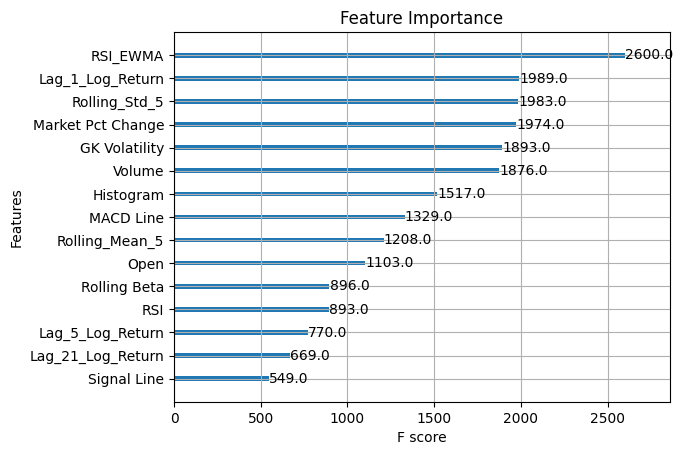

In [90]:
import matplotlib.pyplot as plt

# Feature importance plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=15)
plt.title("Feature Importance")
plt.show()

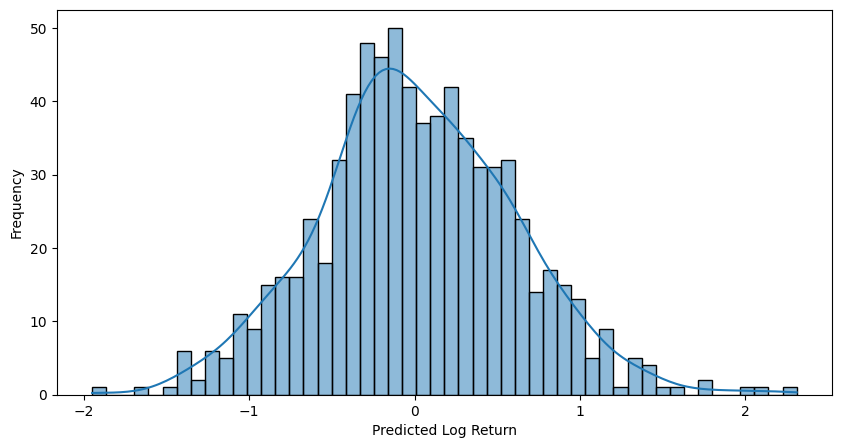

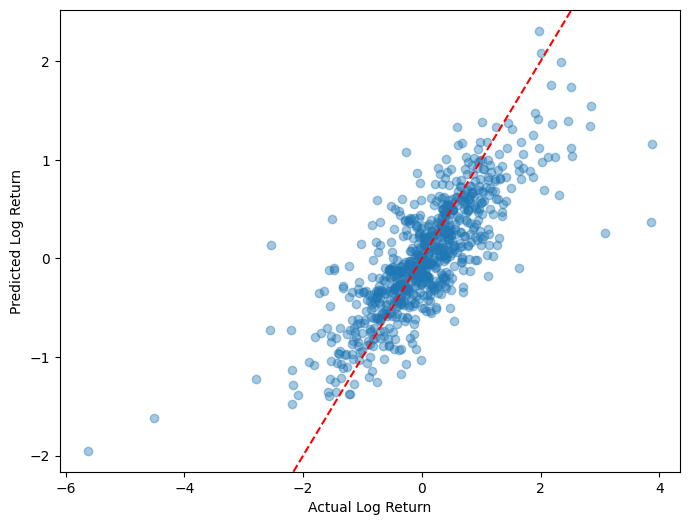

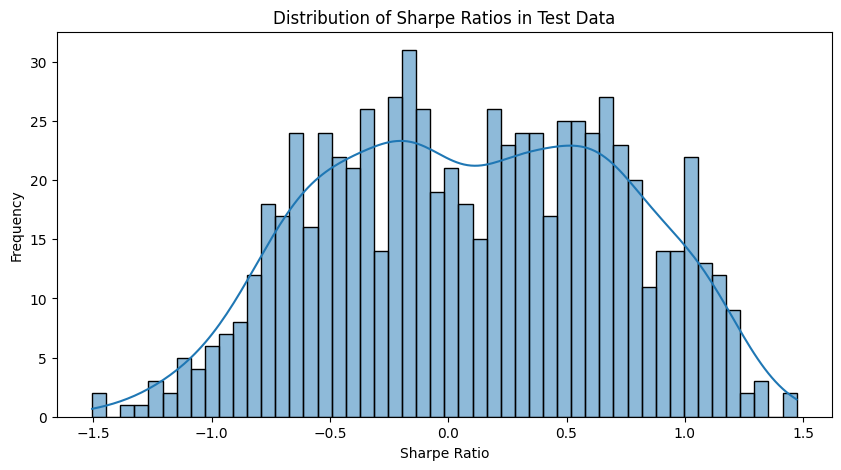

In [94]:
import seaborn as sns

## Histogram of predicted log returns
plt.figure(figsize=(10, 5))
sns.histplot(y_pred, bins=50, kde=True)
plt.xlabel('Predicted Log Return')
plt.ylabel("Frequency")
plt.show()

# Scatter plot: Predicted vs actual Log Returns
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.axline((0,0), slope=1, color='red', linestyle='--') # Reference line to see deviations easily
plt.xlabel("Actual Log Return")
plt.ylabel("Predicted Log Return")
plt.show()

# Histogram of Sharpe Ratios for selected stocks
plt.figure(figsize=(10, 5))
sns.histplot(x_test["Sharpe Ratio"], bins=50, kde=True)
plt.xlabel("Sharpe Ratio")
plt.ylabel("Frequency")
plt.title("Distribution of Sharpe Ratios in Test Data")
plt.show()

## Building out our initial portfolio

In [97]:
# Define aggregation rules
agg_rules = {
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Adj Close': 'last',
    'Volume': 'sum',  # Total trading volume
    'RSI': 'mean',
    'RSI_EWMA': 'mean',
    'Middle Band': 'mean',
    'Upper Band': 'mean',
    'Lower Band': 'mean',
    'MACD Line': 'mean',
    'Signal Line': 'mean',
    'Histogram': 'mean',
    'ATR': 'mean',
    'RoC': 'mean',
    'OBV': 'last',
    'SMA_50': 'mean',
    'EMA_50': 'mean',
    'GK Volatility': 'mean',
    'Market Pct Change': 'sum',  # Accumulate returns over the quarter
    'Rolling Beta': 'mean',
    'Log Return': 'sum',  # Aggregate log returns over the quarter
    'Quarterly Cumulative Return': 'last',  # Keep the latest cumulative return
    'Quarterly Volatility': 'mean',
    'Sharpe Ratio': 'mean',
    'Lag_1_Log_Return': 'sum',
    'Lag_5_Log_Return': 'sum',
    'Lag_21_Log_Return': 'sum',
    'Rolling_Mean_5': 'mean',
    'Rolling_Mean_21': 'mean',
    'Rolling_Mean_63': 'mean',
    'Rolling_Std_5': 'mean',
    'Rolling_Std_21': 'mean',
    'Momentum_Beta_Interaction': 'mean',
    'Sharpe_Momentum_Interaction': 'mean'
}

# Resample to quarterly periods
df_quarterly = df_transformed.groupby(['Ticker', pd.Grouper(level='Date', freq='QE')]).agg(agg_rules)

In [99]:
df_quarterly.tail()

Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
MSFT   2022-12-31  235.410004  263.920013  213.429993  239.820007  235.947845   
       2023-03-31  243.080002  289.269989  219.350006  288.299988  284.355530   
       2023-06-30  286.519989  351.470001  275.369995  340.540009  336.615021   
       2023-09-30  339.190002  366.779999  309.450012  315.750000  312.771545   
       2023-12-31  316.279999  384.299988  311.209991  376.040009  373.248901   

                        Volume       RSI  RSI_EWMA  Middle Band  Upper Band  \
Ticker Date                                                                   
MSFT   2022-12-31  1080.096573 -0.277244 -0.324698     1.678029    1.706633   
       2023-03-31  1070.127929 -0.007213  0.040720     1.813313    1.857699   
       2023-06-30  1059.392058  0.486353  0.465257     2.505027    2.500535   
       2023-09-30  1068.342718 -0.480065 -0.523959     2.872523    2.811564   
       2023-12-31  1071.523559  0.237476  0.319999     3.078608    3.043484   

                   ...  Lag_1_Log_Return  Lag_5_Log_Return  Lag_21_Log_Return  \
Ticker Date        ...                                                          
MSFT   2022-12-31  ...         -2.125100         -2.880171          -4.310441   
       2023-03-31  ...          6.253647          6.222562          -3.799746   
       2023-06-30  ...          6.281523          6.964131          12.036976   
       2023-09-30  ...         -6.665800         -6.064659          -2.914532   
       2023-12-31  ...          7.021096          6.165719           4.917889   

                   Rolling_Mean_5  Rolling_Mean_21  Rolling_Mean_63  \
Ticker Date                                                           
MSFT   2022-12-31       -0.042445        -0.053768        -0.130869   
       2023-03-31        0.101234         0.032377         0.006174   
       2023-06-30        0.111098         0.151831         0.137767   
       2023-09-30       -0.103365        -0.070401         0.002087   
       2023-12-31        0.108563         0.071484         0.017218   

                   Rolling_Std_5  Rolling_Std_21  Momentum_Beta_Interaction  \
Ticker Date                                                                   
MSFT   2022-12-31       1.349467        1.417854                  -0.124697   
       2023-03-31       1.022996        1.065577                   0.083880   
       2023-06-30       0.855835        0.926262                   0.224679   
       2023-09-30       0.733129        0.788526                   0.107640   
       2023-12-31       0.687928        0.740015                   0.056316   

                   Sharpe_Momentum_Interaction  
Ticker Date                                     
MSFT   2022-12-31                     0.102431  
       2023-03-31                     0.014787  
       2023-06-30                     0.167469  
       2023-09-30                     0.039971  
       2023-12-31                     0.059507  

[5 rows x 36 columns]

## An idea would be to merge the quaterly dataset with the daily dataset to provide both short and long term information for the model.

In [131]:
def rebalance_portfolio(df_quarterly, xgb_model, rebalance_dates):
    """
    Function to rebalance our portfolio quarterly based on the results of our XGBoost model.
    """
    portfolio_history = []
    portfolio_value = 1  # Start with an initial portfolio value of 1

    for quarter in rebalance_dates:
        # Select data for the current quarter
        quarter_data = df_quarterly[df_quarterly.index.get_level_values('Date') == quarter].copy()

        # Prepare the data for prediction
        X_quarter = quarter_data.drop(columns=['Log Return'], errors='ignore')

        # Convert DataFrame to DMatrix
        dquarter = xgb.DMatrix(X_quarter)

        # Predict using the trained model
        quarter_data['Predicted Log Return'] = xgb_model.predict(dquarter)

        # Select the top 20 stocks based on predicted returns
        top_20_stocks = quarter_data.nlargest(20, 'Predicted Log Return').copy()

        # Compute risk-adjusted weights based on Sharpe Ratio
        sharpe_ratios = top_20_stocks['Sharpe Ratio']
        weights = sharpe_ratios / sharpe_ratios.sum()

        # Cap weights at 15% per stock and re-normalize
        weights = weights.clip(upper=0.15)  # Cap at 15%
        weights /= weights.sum()  # Ensure the sum of weights equals 1

        # Store portfolio allocation
        top_20_stocks['Weights'] = weights.values
        top_20_stocks['Quarter'] = quarter.strftime('%Y-%m-%d')  # Ensure it's a string

        # Compute portfolio return for the quarter
        portfolio_log_return = (top_20_stocks['Weights'] * top_20_stocks['Log Return']).sum()
        portfolio_value *= np.exp(portfolio_log_return)  # Update portfolio value

        # Store portfolio value
        top_20_stocks['Portfolio Value'] = portfolio_value

        portfolio_history.append(top_20_stocks)

    # Combine results into a final DataFrame
    portfolio_df = pd.concat(portfolio_history).reset_index()

    return portfolio_df


In [133]:
rebalance_dates = df_quarterly.index.get_level_values('Date')[-4:]#.strftime('%Y-%m-%d')
portfolio_results = rebalance_portfolio(df_quarterly, xgb_model, rebalance_dates)

In [135]:
portfolio_results

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume,RSI,RSI_EWMA,...,Rolling_Mean_21,Rolling_Mean_63,Rolling_Std_5,Rolling_Std_21,Momentum_Beta_Interaction,Sharpe_Momentum_Interaction,Predicted Log Return,Weights,Quarter,Portfolio Value
0,GOOGL,2023-03-31,89.589996,108.180000,84.860001,103.730003,103.355331,1081.876753,-0.017734,-0.036882,...,0.010991,-0.042076,1.218116,1.306889,0.006316,0.035866,1.827406,0.333333,2023-03-31,2.664497e+03
1,AAPL,2023-03-31,130.279999,165.000000,124.169998,164.899994,163.433090,1117.183127,0.309903,0.317425,...,0.063189,-0.021943,0.838727,0.924882,0.029236,0.037963,1.555059,0.333333,2023-03-31,2.664497e+03
2,MSFT,2023-03-31,243.080002,289.269989,219.350006,288.299988,284.355530,1070.127929,-0.007213,0.040720,...,0.032377,0.006174,1.022996,1.065577,0.083880,0.014787,1.533679,0.333333,2023-03-31,2.664497e+03
3,GOOGL,2023-06-30,102.389999,129.039993,101.930000,119.699997,119.267639,1071.929289,0.234698,0.265032,...,0.146166,0.113497,0.909491,0.966288,0.188881,0.136062,1.450193,0.333333,2023-06-30,8.738320e+05
4,AAPL,2023-06-30,164.270004,194.479996,159.779999,193.970001,192.510437,1105.443759,0.622993,0.621061,...,0.102905,0.103689,0.604853,0.648120,0.194557,0.155533,1.254297,0.333333,2023-06-30,8.738320e+05
5,MSFT,2023-06-30,286.519989,351.470001,275.369995,340.540009,336.615021,1059.392058,0.486353,0.465257,...,0.151831,0.137767,0.855835,0.926262,0.224679,0.167469,1.241844,0.333333,2023-06-30,8.738320e+05
6,AAPL,2023-09-30,193.779999,198.229996,167.619995,171.210007,170.151169,1123.768399,-0.551534,-0.556816,...,-0.081351,-0.001800,0.684086,0.723222,0.047099,0.065641,-0.957610,-2.121050,2023-09-30,1.069168e-03
7,MSFT,2023-09-30,339.190002,366.779999,309.450012,315.750000,312.771545,1068.342718,-0.480065,-0.523959,...,-0.070401,0.002087,0.733129,0.788526,0.107640,0.039971,-1.020766,5.242099,2023-09-30,1.069168e-03
8,GOOGL,2023-09-30,119.239998,139.160004,115.349998,130.860001,130.387329,1077.723160,0.009556,0.015127,...,0.032554,0.057048,0.828073,0.888903,0.165914,0.044020,-1.837744,-2.121050,2023-09-30,1.069168e-03
9,GOOGL,2023-12-31,131.210007,142.679993,120.209999,139.690002,139.185440,1079.145645,-0.103162,-0.073766,...,-0.042564,-0.015352,0.852093,1.026319,0.048322,0.017080,1.768749,47.481118,2023-12-31,8.342163e-196


### Align historical data with political trade data

In [ ]:
quarterly_aggregated = quarterly_aggregated[quarterly_aggregated['Quarter'] > '2019Q4']
quarterly_aggregated.head()

In [ ]:
quarterly_aggregated['Quarter'] = quarterly_aggregated['Quarter'].dt.to_timestamp(how='end').dt.strftime('%Y-%m-%d')

In [ ]:
df = top_20_stocks_per_quarter.droplevel(level=2)
df.head()

In [ ]:
# df = df[['Adj Close', 'Log Return', 'Momentum Score', 'Sharpe Score', 'Quarterly Score']]
# quarterly_aggregated = quarterly_aggregated[['Ticker', 'Quarter', 'Total_Transactions', 'Signal', 'Confidence']]
# quarterly_aggregated = quarterly_aggregated.rename(columns={'Quarter': 'Date'})
# quarterly_aggregated = quarterly_aggregated.set_index(['Ticker', 'Date'])
# quarterly_aggregated.head()

In [ ]:
quarterly_aggregated

In [ ]:
# df = df.reset_index()
# df = df[df['Date'] >= '2020-03-31']
# df = df.set_index(['Ticker', 'Date'])
# df

In [ ]:
quarterly_aggregated.head()

In [ ]:
# df_combined = quarterly_aggregated.join(df, how='right')